In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn import svm
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

Image shape is (64, 64, 3)


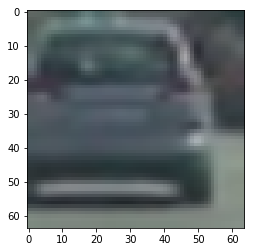

In [72]:
image = cv2.imread('vehicles/GTI_Far/image0006.png')
print('Image shape is', image.shape)
plt.imshow(image[:,:,::-1])

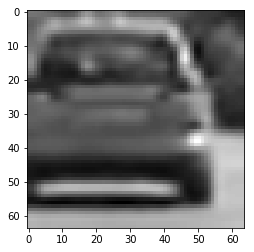

In [3]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

## Classifier

### Data exploration

In [4]:
car_images = glob.glob('vehicles/*/*.png', recursive=True)
nocar_images = glob.glob('non-vehicles/*/*.png', recursive=True)

In [5]:
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = cv2.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

In [6]:
data_look(car_images, nocar_images)

{'data_type': dtype('uint8'),
 'image_shape': (64, 64, 3),
 'n_cars': 8792,
 'n_notcars': 8968}

### Feature extraction

In [7]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True,
                     feature_vec=True):
                         
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=True, 
                                  visualize= vis, feature_vector= feature_vec)
    
    # name returns explicitly
    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features
    
def nomalize(data):
    data = (data-np.min(data))/(np.max(data)-np.min(data))
    return data

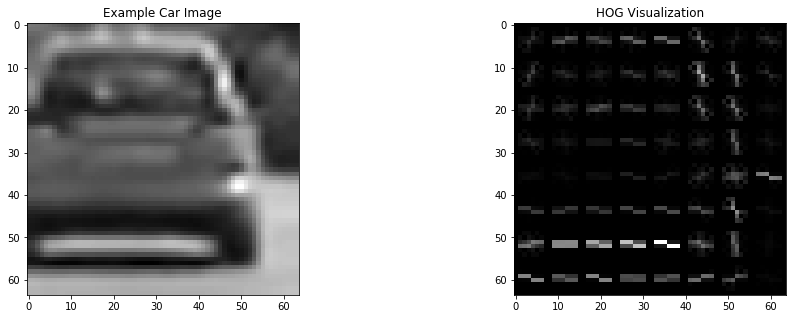

In [9]:
feature, hog_image = get_hog_features(gray, orient=8, 
                        pix_per_cell=8, cell_per_block=2, feature_vec=True)


# Plot the examples
fig = plt.figure(figsize=(16,5))
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [142]:
orient = 8
pix_per_cell = 8
cell_per_block = 2
color_bins = 32
def extract_feature(img):
    global orient, pix_per_cell, cell_per_block, color_bins
    
    color_bins_range = (np.min(img), np.max(img))
    color_feature = color_hist(img, color_bins, color_bins_range)
    color_feature = nomalize(color_feature)
    
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    hog_features = []
    for i in range(3):
        hog_feature,_ = get_hog_features(ycrcb[:,:,i], orient, pix_per_cell, cell_per_block)
        hog_features.extend(hog_feature)
    
    
    return np.concatenate((color_feature, hog_features))

def pre_extract_feature(img):
    global orient, pix_per_cell, cell_per_block, color_bins
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_feature,_ = get_hog_features(gray, orient, pix_per_cell, cell_per_block)
#     color_bins_range = (np.min(img), np.max(img))
#     color_feature = color_hist(img, color_bins, color_bins_range)
#     color_feature = nomalize(color_feature)

    return hog_feature


In [143]:
import datetime
start_time = datetime.datetime.now()

pre_features = []
pre_labels = []

for img_name in car_images:
    img = cv2.imread(img_name)
    feature = pre_extract_feature(img)
    pre_features.append(feature)
    pre_labels.append(1)
    
for img_name in nocar_images:
    img = cv2.imread(img_name)
    feature = pre_extract_feature(img)
    pre_features.append(feature)
    pre_labels.append(0)
    
stop_time = datetime.datetime.now()
print((stop_time - start_time).seconds)

165


In [15]:
features = []
labels = []

for img_name in car_images:
    img = cv2.imread(img_name)
    feature = extract_feature(img)
    features.append(feature)
    labels.append(1)
    
for img_name in nocar_images:
    img = cv2.imread(img_name)
    feature = extract_feature(img)
    features.append(feature)
    labels.append(0)

In [144]:
pre_train_features, pre_test_features, pre_train_labels, pre_test_labels = train_test_split(pre_features, pre_labels, test_size=0.2)

In [16]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2)

In [145]:
pre_scaler = StandardScaler()
pre_scaler.fit(pre_train_features)
pre_train_features = pre_scaler.transform(pre_train_features)

In [17]:
scaler = StandardScaler()
scaler.fit(train_features)
train_features = scaler.transform(train_features)

### SVM

In [146]:
pre_clf = svm.LinearSVC(C=1)

In [147]:
start_time = datetime.datetime.now()
pre_clf.fit(pre_train_features, pre_train_labels)  
stop_time = datetime.datetime.now()
print((stop_time - start_time).seconds)

5


In [148]:
pre_accuracy = []
for pre_test_feature, pre_test_label in zip(pre_test_features, pre_test_labels):
    if pre_clf.predict(pre_scaler.transform(pre_test_feature.reshape(1,-1))) == pre_test_label:
        pre_accuracy.append(1)
    else:
        pre_accuracy.append(0)
print('True count is', pre_accuracy.count(1))
print('False count is', pre_accuracy.count(0))
print('Accuracy is', np.mean(pre_accuracy))

True count is 3348
False count is 204
Accuracy is 0.942567567568


In [18]:
clf = svm.LinearSVC(C=1)

In [19]:
clf.fit(train_features, train_labels)  

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [20]:
accuracy = []
for test_feature, test_label in zip(test_features, test_labels):
    if clf.predict(scaler.transform(test_feature.reshape(1,-1))) == test_label:
        accuracy.append(1)
    else:
        accuracy.append(0)
print('True count is', accuracy.count(1))
print('False count is', accuracy.count(0))
print('Accuracy is', np.mean(accuracy))

True count is 3500
False count is 52
Accuracy is 0.98536036036


## Sliding window

In [21]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

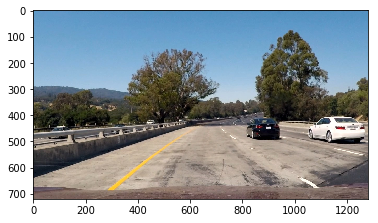

In [22]:
test_image = cv2.imread('test_images/test1.jpg')
plt.imshow(test_image[:,:,::-1])

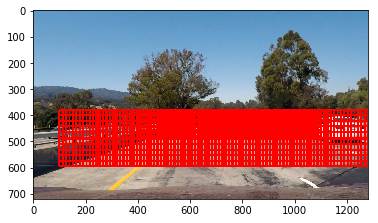

In [168]:
all_windows = []

windows = slide_window(test_image, x_start_stop=[400, 1100], y_start_stop=[380, 500], 
                    xy_window=(64, 64), xy_overlap=(0.8, 0.8))

all_windows.extend(windows)

windows = slide_window(test_image, x_start_stop=[100, None], y_start_stop=[380, 600], 
                    xy_window=(140, 110), xy_overlap=(0.9, 0.8))

all_windows.extend(windows)
    
windows = slide_window(test_image, x_start_stop=[100, None], y_start_stop=[350, 600], 
                    xy_window=(180, 150), xy_overlap=(0.8, 0.8))
    
# all_windows.extend(windows)
    
window_img = draw_boxes(test_image, all_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img[:,:,::-1])

### Predict

In [107]:
def pre_predict_windows(img, all_windows, classifier, scaler):
    on_windows = []
    
    for window in all_windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
        feature  = pre_extract_feature(test_img)
    
        feature = scaler.transform(np.array(feature).reshape(1, -1))
        prediction = classifier.predict(feature)
        
        if prediction == 1:
            on_windows.append(window)
        
    return on_windows

In [24]:
def predict_windows(img, all_windows, classifier, scaler):
    on_windows = []
    
    for window in all_windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
        feature  = extract_feature(test_img)
    
        feature = scaler.transform(np.array(feature).reshape(1, -1))
        prediction = classifier.predict(feature)
        
        if prediction == 1:
            on_windows.append(window)
        
    return on_windows
    

In [169]:
pre_windows = pre_predict_windows(test_image, all_windows=all_windows, classifier=pre_clf, scaler=pre_scaler)

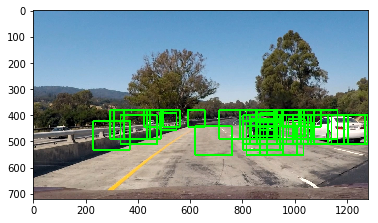

In [170]:
pre_windows_img = draw_boxes(test_image, pre_windows, color=(0, 255, 0), thick=6)  
plt.imshow(pre_windows_img[:,:,::-1])

In [171]:
aa = predict_windows(test_image, all_windows=pre_windows, classifier=clf, scaler=scaler)

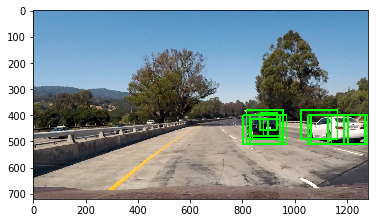

In [172]:
bb = draw_boxes(test_image, aa, color=(0, 255, 0), thick=6)  
plt.imshow(bb[:,:,::-1])

### Multiple Detections & False Positives

In [27]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [28]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [29]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

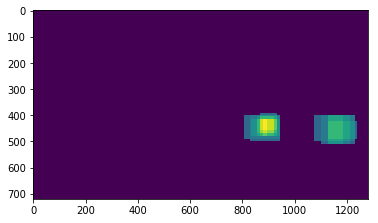

In [77]:
heat_map = np.zeros((test_image.shape[0], test_image.shape[1]))
heat_map = add_heat(heat_map, aa)
heat_map = apply_threshold(heat_map, 3)

plt.imshow(heat_map)

2 cars found


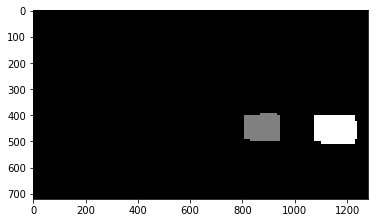

In [78]:
labels = label(heat_map)

print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

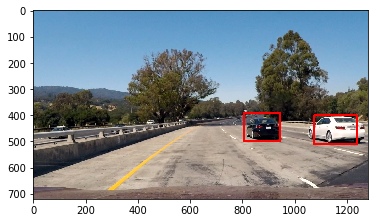

In [79]:
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

plt.imshow(draw_img[:,:,::-1])

## Pipeline

In [32]:
from moviepy.editor import VideoFileClip

In [134]:
wins = []
def video_pipeline(img):
    global clf, scaler, pre_clf, pre_scaler, all_windows
    global wins
    
    img = img[:,:,::-1]
    
    pre_win = pre_predict_windows(img, all_windows=all_windows, classifier=pre_clf, scaler=pre_scaler)
    
    win = predict_windows(img, all_windows=pre_win, classifier=clf, scaler=scaler)
    heat_map = np.zeros((img.shape[0], img.shape[1]))
    
    
    wins.append(win)
    if len(wins)>10:
        wins.pop(0)
    
    for win in wins:
        heat_map = add_heat(heat_map, win)
    
    heat_map = apply_threshold(heat_map, 2)

    
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img[:,:,::-1]
    
    

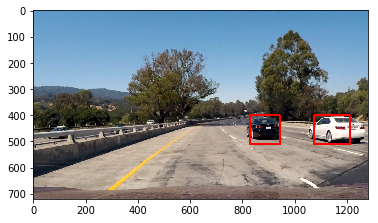

In [113]:
pipeline_test = video_pipeline(test_image[:,:,::-1])
plt.imshow(pipeline_test)

In [173]:
wins = []
output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4






  0%|          | 0/39 [00:00<?, ?it/s]



  3%|▎         | 1/39 [00:07<05:02,  7.95s/it]



  5%|▌         | 2/39 [00:15<04:51,  7.88s/it]



  8%|▊         | 3/39 [00:23<04:43,  7.87s/it]



 10%|█         | 4/39 [00:31<04:36,  7.89s/it]



 13%|█▎        | 5/39 [00:39<04:27,  7.86s/it]



 15%|█▌        | 6/39 [00:47<04:19,  7.87s/it]



 18%|█▊        | 7/39 [00:55<04:12,  7.90s/it]



 21%|██        | 8/39 [01:03<04:06,  7.97s/it]



 23%|██▎       | 9/39 [01:11<03:59,  8.00s/it]



 26%|██▌       | 10/39 [01:20<03:52,  8.02s/it]



 28%|██▊       | 11/39 [01:29<03:48,  8.15s/it]



 31%|███       | 12/39 [01:38<03:42,  8.23s/it]



 33%|███▎      | 13/39 [01:48<03:36,  8.33s/it]



 36%|███▌      | 14/39 [01:56<03:28,  8.35s/it]



 38%|███▊      | 15/39 [02:05<03:20,  8.36s/it]



 41%|████      | 16/39 [02:14<03:12,  8.39s/it]



 44%|████▎     | 17/39 [02:23<03:05,  8.41s/it]



 46%|████▌     | 18/39 [02:31<02:56,  8.43s/it]



 49%|████▊     | 19/39 [02:41<02:49,  8.49s/i

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 5min 35s, sys: 304 ms, total: 5min 35s
Wall time: 5min 36s


In [174]:
wins = []
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4






  0%|          | 0/1261 [00:00<?, ?it/s]



  0%|          | 1/1261 [00:07<2:31:32,  7.22s/it]



  0%|          | 2/1261 [00:14<2:33:47,  7.33s/it]



  0%|          | 3/1261 [00:21<2:32:25,  7.27s/it]



  0%|          | 4/1261 [00:29<2:32:34,  7.28s/it]



  0%|          | 5/1261 [00:36<2:33:05,  7.31s/it]



  0%|          | 6/1261 [00:43<2:31:54,  7.26s/it]



  1%|          | 7/1261 [00:50<2:31:25,  7.25s/it]



  1%|          | 8/1261 [00:57<2:31:23,  7.25s/it]



  1%|          | 9/1261 [01:05<2:31:43,  7.27s/it]



  1%|          | 10/1261 [01:13<2:32:31,  7.32s/it]



  1%|          | 11/1261 [01:20<2:32:54,  7.34s/it]



  1%|          | 12/1261 [01:28<2:33:23,  7.37s/it]



  1%|          | 13/1261 [01:35<2:33:29,  7.38s/it]



  1%|          | 14/1261 [01:43<2:33:38,  7.39s/it]



  1%|          | 15/1261 [01:50<2:33:35,  7.40s/it]



  1%|▏         | 16/1261 [01:58<2:33:41,  7.41s/it]



  1%|▏         | 17/1261 [02:06<2:33:40,  7.41s/it]



  1%|▏         | 18/1261 [

 10%|▉         | 122/1261 [15:07<2:21:13,  7.44s/it]



 10%|▉         | 123/1261 [15:15<2:21:05,  7.44s/it]



 10%|▉         | 124/1261 [15:22<2:20:57,  7.44s/it]



 10%|▉         | 125/1261 [15:29<2:20:48,  7.44s/it]



 10%|▉         | 126/1261 [15:36<2:20:39,  7.44s/it]



 10%|█         | 127/1261 [15:44<2:20:32,  7.44s/it]



 10%|█         | 128/1261 [15:51<2:20:24,  7.44s/it]



 10%|█         | 129/1261 [15:59<2:20:17,  7.44s/it]



 10%|█         | 130/1261 [16:06<2:20:11,  7.44s/it]



 10%|█         | 131/1261 [16:14<2:20:03,  7.44s/it]



 10%|█         | 132/1261 [16:21<2:19:56,  7.44s/it]



 11%|█         | 133/1261 [16:29<2:19:48,  7.44s/it]



 11%|█         | 134/1261 [16:36<2:19:39,  7.44s/it]



 11%|█         | 135/1261 [16:43<2:19:30,  7.43s/it]



 11%|█         | 136/1261 [16:50<2:19:22,  7.43s/it]



 11%|█         | 137/1261 [16:58<2:19:15,  7.43s/it]



 11%|█         | 138/1261 [17:05<2:19:06,  7.43s/it]



 11%|█         | 139/1261 [17:13<2:18:58,  7.43s

 19%|█▉        | 242/1261 [31:16<2:11:41,  7.75s/it]



 19%|█▉        | 243/1261 [31:25<2:11:38,  7.76s/it]



 19%|█▉        | 244/1261 [31:33<2:11:32,  7.76s/it]



 19%|█▉        | 245/1261 [31:41<2:11:26,  7.76s/it]



 20%|█▉        | 246/1261 [31:49<2:11:20,  7.76s/it]



 20%|█▉        | 247/1261 [31:58<2:11:14,  7.77s/it]



 20%|█▉        | 248/1261 [32:06<2:11:07,  7.77s/it]



 20%|█▉        | 249/1261 [32:14<2:11:02,  7.77s/it]



 20%|█▉        | 250/1261 [32:23<2:11:00,  7.77s/it]



 20%|█▉        | 251/1261 [32:32<2:10:57,  7.78s/it]



 20%|█▉        | 252/1261 [32:41<2:10:52,  7.78s/it]



 20%|██        | 253/1261 [32:49<2:10:48,  7.79s/it]



 20%|██        | 254/1261 [32:59<2:10:47,  7.79s/it]



 20%|██        | 255/1261 [33:07<2:10:42,  7.80s/it]



 20%|██        | 256/1261 [33:16<2:10:36,  7.80s/it]



 20%|██        | 257/1261 [33:23<2:10:27,  7.80s/it]



 20%|██        | 258/1261 [33:31<2:10:19,  7.80s/it]



 21%|██        | 259/1261 [33:39<2:10:13,  7.80s

 29%|██▊       | 362/1261 [48:30<2:00:27,  8.04s/it]



 29%|██▉       | 363/1261 [48:39<2:00:23,  8.04s/it]



 29%|██▉       | 364/1261 [48:48<2:00:16,  8.04s/it]



 29%|██▉       | 365/1261 [48:56<2:00:08,  8.04s/it]



 29%|██▉       | 366/1261 [49:04<2:00:00,  8.05s/it]



 29%|██▉       | 367/1261 [49:13<1:59:54,  8.05s/it]



 29%|██▉       | 368/1261 [49:22<1:59:49,  8.05s/it]



 29%|██▉       | 369/1261 [49:32<1:59:44,  8.05s/it]



 29%|██▉       | 370/1261 [49:40<1:59:38,  8.06s/it]



 29%|██▉       | 371/1261 [49:50<1:59:33,  8.06s/it]



 30%|██▉       | 372/1261 [49:59<1:59:28,  8.06s/it]



 30%|██▉       | 373/1261 [50:08<1:59:23,  8.07s/it]



 30%|██▉       | 374/1261 [50:17<1:59:15,  8.07s/it]



 30%|██▉       | 375/1261 [50:26<1:59:10,  8.07s/it]



 30%|██▉       | 376/1261 [50:35<1:59:05,  8.07s/it]



 30%|██▉       | 377/1261 [50:45<1:59:00,  8.08s/it]



 30%|██▉       | 378/1261 [50:53<1:58:53,  8.08s/it]



 30%|███       | 379/1261 [51:02<1:58:47,  8.08s

 38%|███▊      | 481/1261 [1:05:17<1:45:53,  8.15s/it]



 38%|███▊      | 482/1261 [1:05:26<1:45:45,  8.15s/it]



 38%|███▊      | 483/1261 [1:05:34<1:45:36,  8.15s/it]



 38%|███▊      | 484/1261 [1:05:41<1:45:28,  8.14s/it]



 38%|███▊      | 485/1261 [1:05:49<1:45:19,  8.14s/it]



 39%|███▊      | 486/1261 [1:05:57<1:45:11,  8.14s/it]



 39%|███▊      | 487/1261 [1:06:05<1:45:02,  8.14s/it]



 39%|███▊      | 488/1261 [1:06:13<1:44:54,  8.14s/it]



 39%|███▉      | 489/1261 [1:06:21<1:44:46,  8.14s/it]



 39%|███▉      | 490/1261 [1:06:29<1:44:38,  8.14s/it]



 39%|███▉      | 491/1261 [1:06:38<1:44:29,  8.14s/it]



 39%|███▉      | 492/1261 [1:06:46<1:44:21,  8.14s/it]



 39%|███▉      | 493/1261 [1:06:54<1:44:13,  8.14s/it]



 39%|███▉      | 494/1261 [1:07:02<1:44:04,  8.14s/it]



 39%|███▉      | 495/1261 [1:07:10<1:43:56,  8.14s/it]



 39%|███▉      | 496/1261 [1:07:17<1:43:47,  8.14s/it]



 39%|███▉      | 497/1261 [1:07:26<1:43:39,  8.14s/it]



 39%|███▉     

 47%|████▋     | 598/1261 [1:21:50<1:30:44,  8.21s/it]



 48%|████▊     | 599/1261 [1:22:00<1:30:37,  8.21s/it]



 48%|████▊     | 600/1261 [1:22:09<1:30:30,  8.22s/it]



 48%|████▊     | 601/1261 [1:22:19<1:30:24,  8.22s/it]



 48%|████▊     | 602/1261 [1:22:31<1:30:19,  8.22s/it]



 48%|████▊     | 603/1261 [1:22:41<1:30:13,  8.23s/it]



 48%|████▊     | 604/1261 [1:22:50<1:30:06,  8.23s/it]



 48%|████▊     | 605/1261 [1:22:59<1:29:59,  8.23s/it]



 48%|████▊     | 606/1261 [1:23:08<1:29:52,  8.23s/it]



 48%|████▊     | 607/1261 [1:23:17<1:29:44,  8.23s/it]



 48%|████▊     | 608/1261 [1:23:25<1:29:36,  8.23s/it]



 48%|████▊     | 609/1261 [1:23:34<1:29:28,  8.23s/it]



 48%|████▊     | 610/1261 [1:23:42<1:29:20,  8.23s/it]



 48%|████▊     | 611/1261 [1:23:51<1:29:12,  8.23s/it]



 49%|████▊     | 612/1261 [1:23:59<1:29:04,  8.23s/it]



 49%|████▊     | 613/1261 [1:24:08<1:28:56,  8.24s/it]



 49%|████▊     | 614/1261 [1:24:17<1:28:49,  8.24s/it]



 49%|████▉    

 57%|█████▋    | 715/1261 [1:38:02<1:14:51,  8.23s/it]



 57%|█████▋    | 716/1261 [1:38:10<1:14:43,  8.23s/it]



 57%|█████▋    | 717/1261 [1:38:19<1:14:35,  8.23s/it]



 57%|█████▋    | 718/1261 [1:38:27<1:14:27,  8.23s/it]



 57%|█████▋    | 719/1261 [1:38:35<1:14:19,  8.23s/it]



 57%|█████▋    | 720/1261 [1:38:44<1:14:11,  8.23s/it]



 57%|█████▋    | 721/1261 [1:38:53<1:14:03,  8.23s/it]



 57%|█████▋    | 722/1261 [1:39:01<1:13:55,  8.23s/it]



 57%|█████▋    | 723/1261 [1:39:09<1:13:46,  8.23s/it]



 57%|█████▋    | 724/1261 [1:39:17<1:13:38,  8.23s/it]



 57%|█████▋    | 725/1261 [1:39:24<1:13:29,  8.23s/it]



 58%|█████▊    | 726/1261 [1:39:32<1:13:21,  8.23s/it]



 58%|█████▊    | 727/1261 [1:39:40<1:13:12,  8.23s/it]



 58%|█████▊    | 728/1261 [1:39:48<1:13:04,  8.23s/it]



 58%|█████▊    | 729/1261 [1:39:56<1:12:55,  8.23s/it]



 58%|█████▊    | 730/1261 [1:40:03<1:12:47,  8.22s/it]



 58%|█████▊    | 731/1261 [1:40:11<1:12:38,  8.22s/it]



 58%|█████▊   

 66%|██████▌   | 832/1261 [1:53:44<58:38,  8.20s/it]



 66%|██████▌   | 833/1261 [1:53:51<58:30,  8.20s/it]



 66%|██████▌   | 834/1261 [1:53:59<58:21,  8.20s/it]



 66%|██████▌   | 835/1261 [1:54:07<58:13,  8.20s/it]



 66%|██████▋   | 836/1261 [1:54:15<58:04,  8.20s/it]



 66%|██████▋   | 837/1261 [1:54:22<57:56,  8.20s/it]



 66%|██████▋   | 838/1261 [1:54:30<57:48,  8.20s/it]



 67%|██████▋   | 839/1261 [1:54:38<57:39,  8.20s/it]



 67%|██████▋   | 840/1261 [1:54:46<57:31,  8.20s/it]



 67%|██████▋   | 841/1261 [1:54:54<57:23,  8.20s/it]



 67%|██████▋   | 842/1261 [1:55:02<57:14,  8.20s/it]



 67%|██████▋   | 843/1261 [1:55:09<57:06,  8.20s/it]



 67%|██████▋   | 844/1261 [1:55:17<56:57,  8.20s/it]



 67%|██████▋   | 845/1261 [1:55:25<56:49,  8.20s/it]



 67%|██████▋   | 846/1261 [1:55:33<56:41,  8.20s/it]



 67%|██████▋   | 847/1261 [1:55:41<56:32,  8.20s/it]



 67%|██████▋   | 848/1261 [1:55:49<56:24,  8.19s/it]



 67%|██████▋   | 849/1261 [1:55:57<56:16,  8.19s

 75%|███████▌  | 952/1261 [2:09:43<42:06,  8.18s/it]



 76%|███████▌  | 953/1261 [2:09:51<41:58,  8.18s/it]



 76%|███████▌  | 954/1261 [2:10:00<41:50,  8.18s/it]



 76%|███████▌  | 955/1261 [2:10:08<41:41,  8.18s/it]



 76%|███████▌  | 956/1261 [2:10:16<41:33,  8.18s/it]



 76%|███████▌  | 957/1261 [2:10:25<41:25,  8.18s/it]



 76%|███████▌  | 958/1261 [2:10:33<41:17,  8.18s/it]



 76%|███████▌  | 959/1261 [2:10:41<41:09,  8.18s/it]



 76%|███████▌  | 960/1261 [2:10:49<41:01,  8.18s/it]



 76%|███████▌  | 961/1261 [2:10:57<40:53,  8.18s/it]



 76%|███████▋  | 962/1261 [2:11:06<40:44,  8.18s/it]



 76%|███████▋  | 963/1261 [2:11:13<40:36,  8.18s/it]



 76%|███████▋  | 964/1261 [2:11:22<40:28,  8.18s/it]



 77%|███████▋  | 965/1261 [2:11:30<40:20,  8.18s/it]



 77%|███████▋  | 966/1261 [2:11:38<40:11,  8.18s/it]



 77%|███████▋  | 967/1261 [2:11:46<40:03,  8.18s/it]



 77%|███████▋  | 968/1261 [2:11:54<39:55,  8.18s/it]



 77%|███████▋  | 969/1261 [2:12:02<39:47,  8.18s

 85%|████████▍ | 1071/1261 [2:26:11<25:56,  8.19s/it]



 85%|████████▌ | 1072/1261 [2:26:19<25:47,  8.19s/it]



 85%|████████▌ | 1073/1261 [2:26:27<25:39,  8.19s/it]



 85%|████████▌ | 1074/1261 [2:26:35<25:31,  8.19s/it]



 85%|████████▌ | 1075/1261 [2:26:44<25:23,  8.19s/it]



 85%|████████▌ | 1076/1261 [2:26:52<25:15,  8.19s/it]



 85%|████████▌ | 1077/1261 [2:27:01<25:07,  8.19s/it]



 85%|████████▌ | 1078/1261 [2:27:09<24:58,  8.19s/it]



 86%|████████▌ | 1079/1261 [2:27:17<24:50,  8.19s/it]



 86%|████████▌ | 1080/1261 [2:27:26<24:42,  8.19s/it]



 86%|████████▌ | 1081/1261 [2:27:34<24:34,  8.19s/it]



 86%|████████▌ | 1082/1261 [2:27:42<24:26,  8.19s/it]



 86%|████████▌ | 1083/1261 [2:27:50<24:17,  8.19s/it]



 86%|████████▌ | 1084/1261 [2:27:58<24:09,  8.19s/it]



 86%|████████▌ | 1085/1261 [2:28:06<24:01,  8.19s/it]



 86%|████████▌ | 1086/1261 [2:28:14<23:53,  8.19s/it]



 86%|████████▌ | 1087/1261 [2:28:22<23:45,  8.19s/it]



 86%|████████▋ | 1088/1261 [2:2

 94%|█████████▍| 1189/1261 [2:41:56<09:48,  8.17s/it]



 94%|█████████▍| 1190/1261 [2:42:04<09:40,  8.17s/it]



 94%|█████████▍| 1191/1261 [2:42:11<09:31,  8.17s/it]



 95%|█████████▍| 1192/1261 [2:42:19<09:23,  8.17s/it]



 95%|█████████▍| 1193/1261 [2:42:27<09:15,  8.17s/it]



 95%|█████████▍| 1194/1261 [2:42:35<09:07,  8.17s/it]



 95%|█████████▍| 1195/1261 [2:42:42<08:59,  8.17s/it]



 95%|█████████▍| 1196/1261 [2:42:49<08:50,  8.17s/it]



 95%|█████████▍| 1197/1261 [2:42:58<08:42,  8.17s/it]



 95%|█████████▌| 1198/1261 [2:43:05<08:34,  8.17s/it]



 95%|█████████▌| 1199/1261 [2:43:13<08:26,  8.17s/it]



 95%|█████████▌| 1200/1261 [2:43:21<08:18,  8.17s/it]



 95%|█████████▌| 1201/1261 [2:43:30<08:10,  8.17s/it]



 95%|█████████▌| 1202/1261 [2:43:38<08:01,  8.17s/it]



 95%|█████████▌| 1203/1261 [2:43:45<07:53,  8.17s/it]



 95%|█████████▌| 1204/1261 [2:43:53<07:45,  8.17s/it]



 96%|█████████▌| 1205/1261 [2:44:00<07:37,  8.17s/it]



 96%|█████████▌| 1206/1261 [2:4

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2h 51min 11s, sys: 8.89 s, total: 2h 51min 20s
Wall time: 2h 51min 13s
